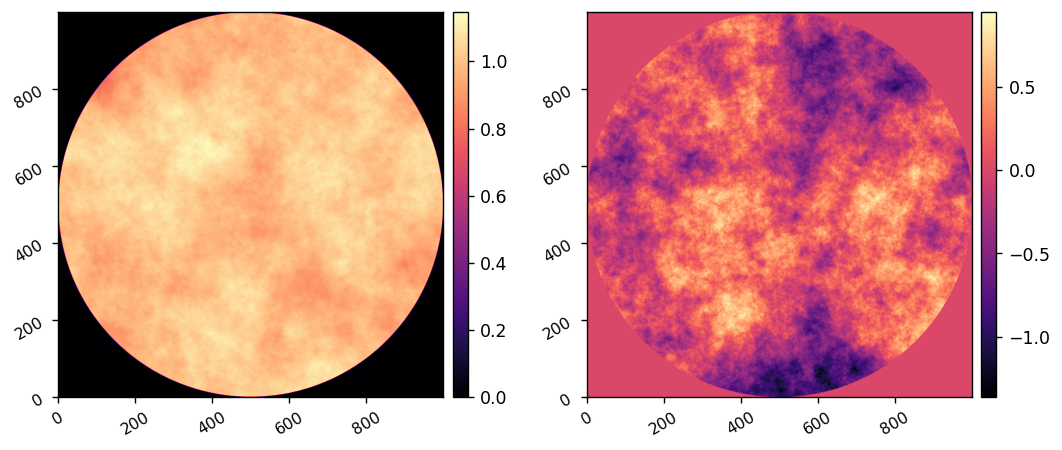

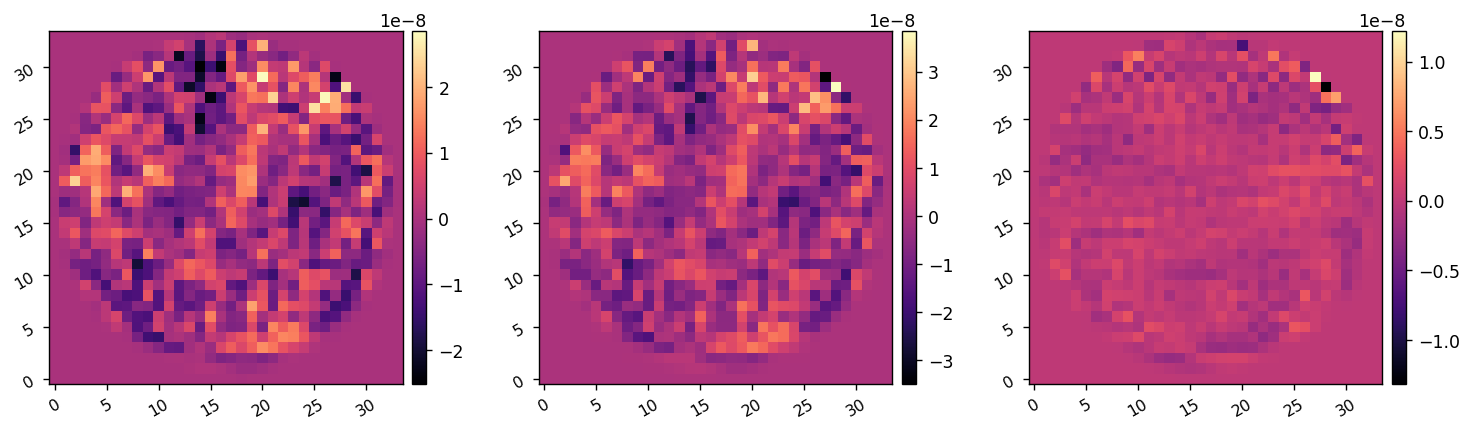

In [113]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoob_fraunhofer as scoob
import scoobpsf.utils as utils
import scoobpsf.dm as dm

import lina

wavelength_c = 633*u.nm
pupil_diam = 10*u.mm

reload(utils)
wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)

dh_commands = utils.load_fits('scoob_fraunhofer_dh_commands_0.fits')
dh_commands = xp.array([xp.zeros((34,34)), dh_commands[2], dh_commands[6], dh_commands[12], dh_commands[-1]])
imshow3(dh_commands[2], dh_commands[-1], dh_commands[2]-dh_commands[-1])

Oversampling > 2x suggested for reliable results in Fresnel propagation.


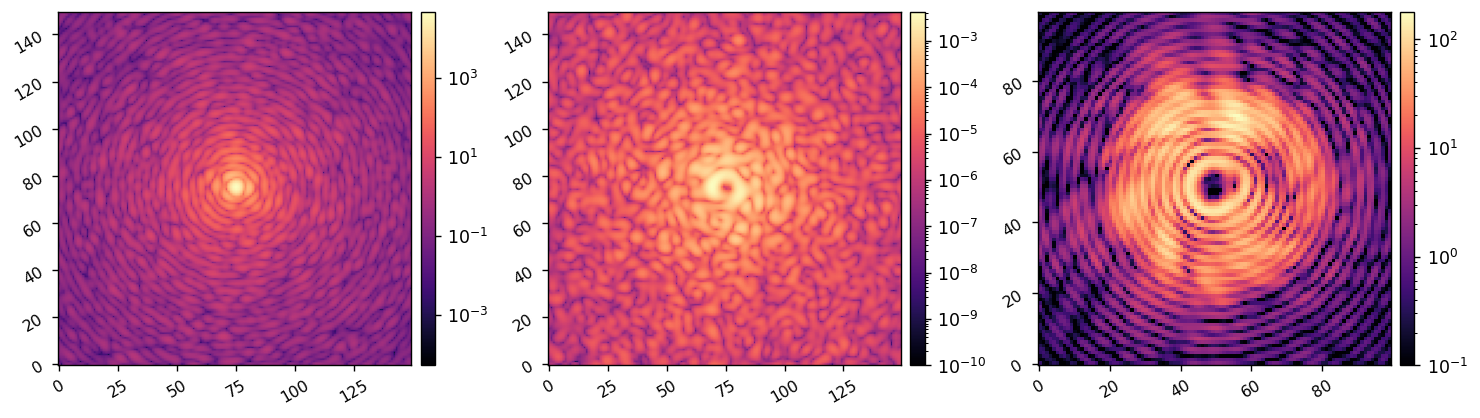

In [188]:
import copy
reload(scoob)
M = scoob.single()
M.setattr('WFE', WFE)
M.setattr('llowfsc_defocus', 2.75*u.mm)
M.setattr('nlocam', 100)
# M.set_dm(dh_commands[-1])

M.setattr('use_vortex', False)
ref_psf = M.snap()

M.setattr('Imax_ref', xp.max(ref_psf))
M.setattr('use_vortex', True)
coro_im = M.snap()

locam_ref_im = M.snap_locam()

coro_roi = lina.utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, 3, 12, edge=3, )
imshow3(ref_psf, coro_im, locam_ref_im, lognorm=True, vmin2=1e-10, vmin3=1e-1)

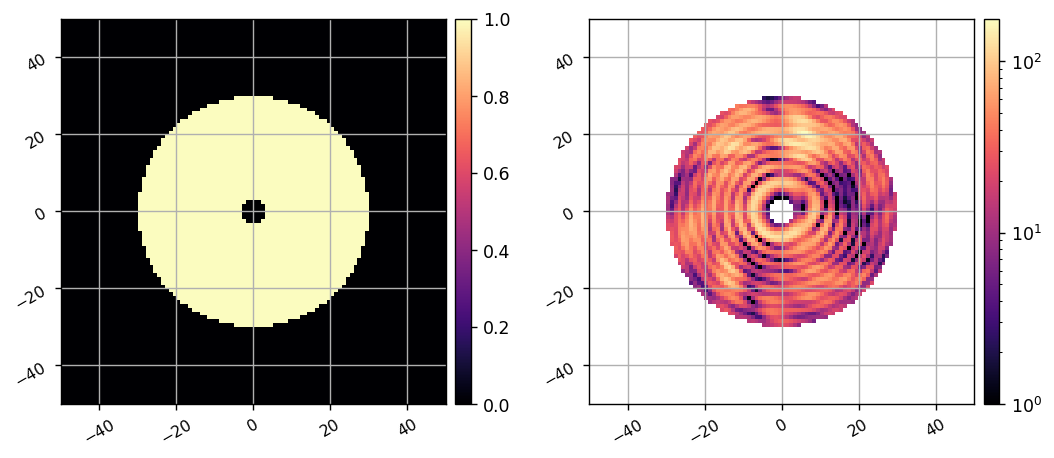

In [187]:
irad = 3
orad = 30
control_mask = lina.utils.create_annular_focal_plane_mask(M.nlocam, 1, irad, orad, edge=None, )
# control_mask = xp.ones((M.nlocam, M.nlocam)).astype(bool)
imshow2(control_mask, locam_ref_im * control_mask, grid=True, pxscl=1, lognorm2=True, vmin2=10e-1)

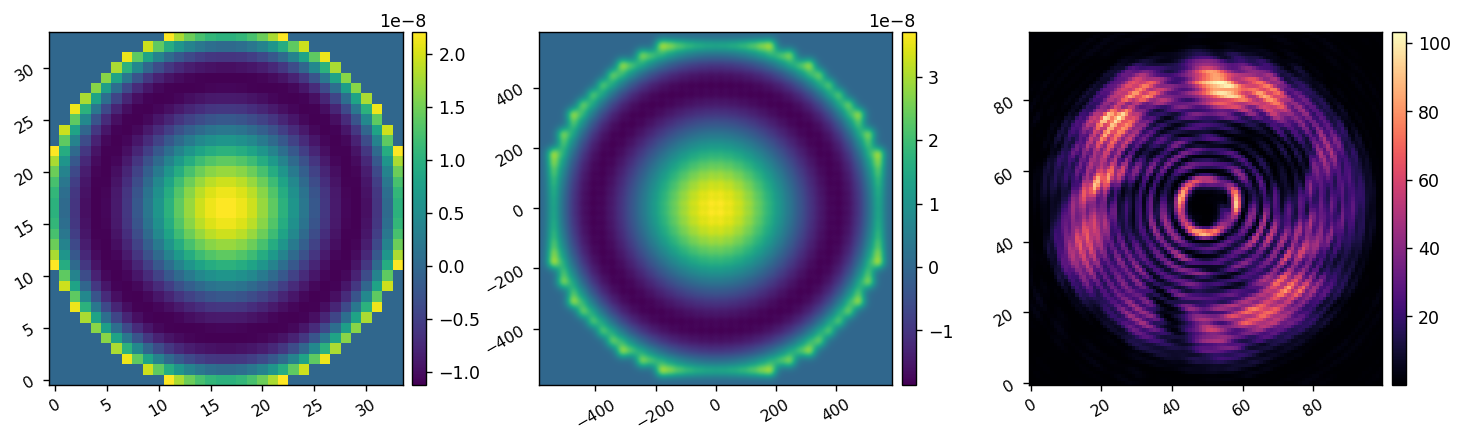

In [168]:
reload(lina.utils)
M.zero_dm()
dm_modes = lina.utils.create_zernike_modes(M.dm_mask, nmodes=10, remove_modes=1)
i = -1
amp = 10e-9
M.add_dm(amp*dm_modes[i])
locam_im = M.snap_locam()
imshow3(amp*dm_modes[i], M.DM.get_surface(), locam_im, cmap1='viridis', cmap2='viridis', pxscl2=1)

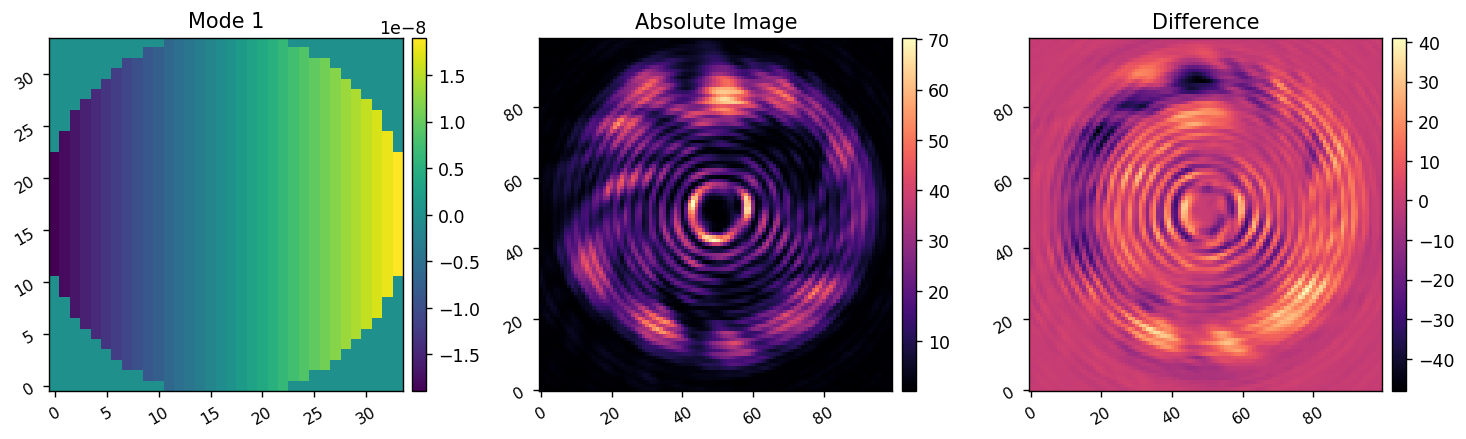

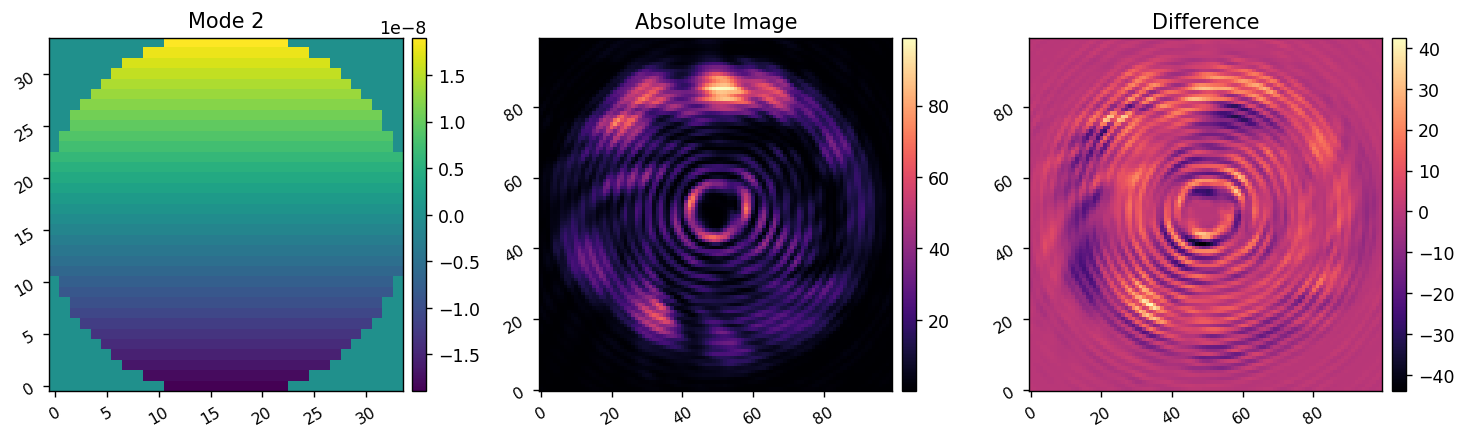

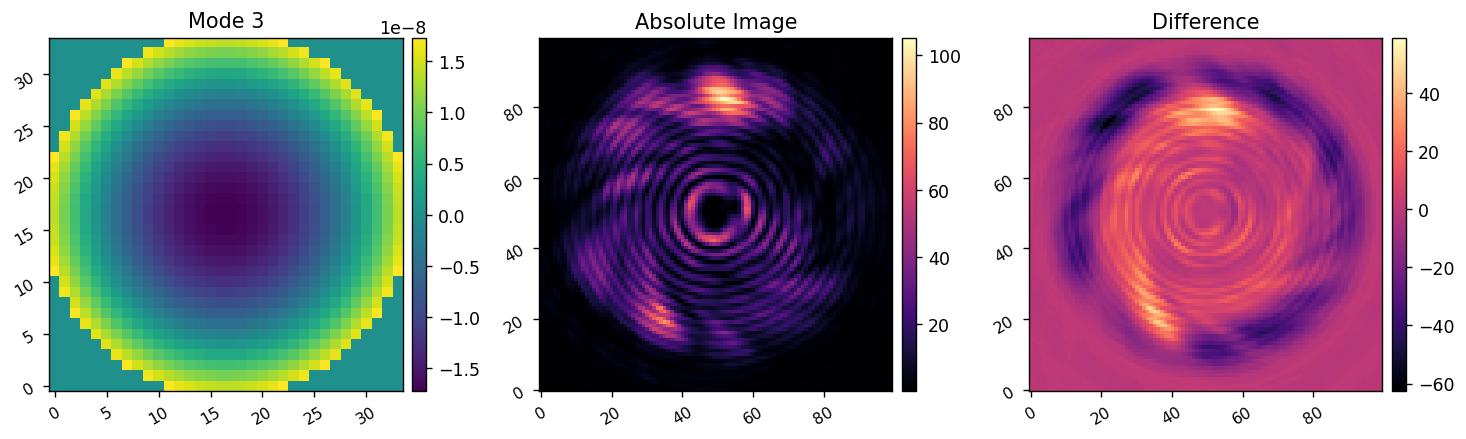

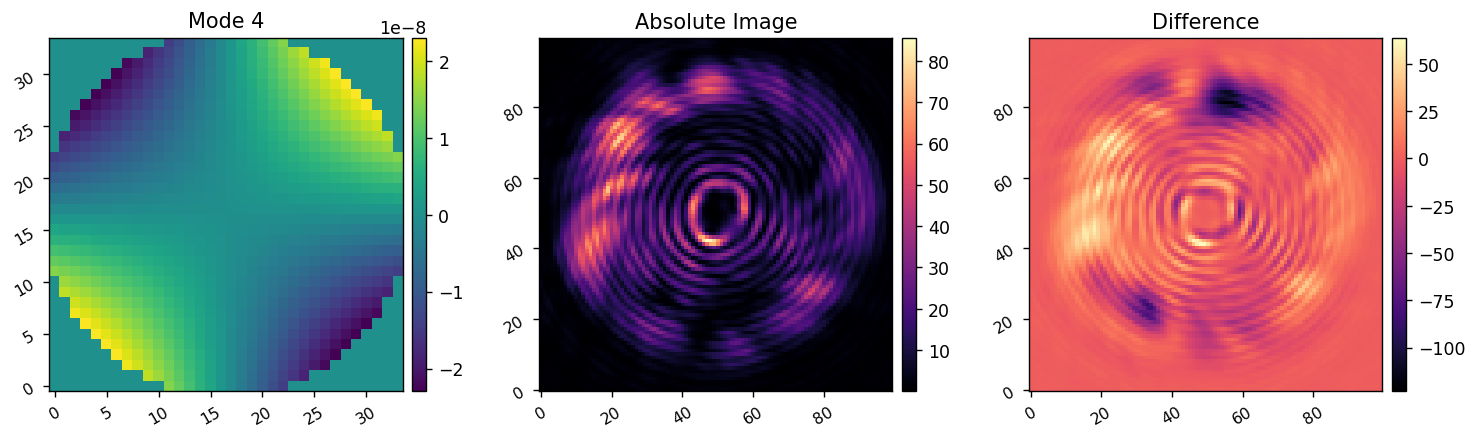

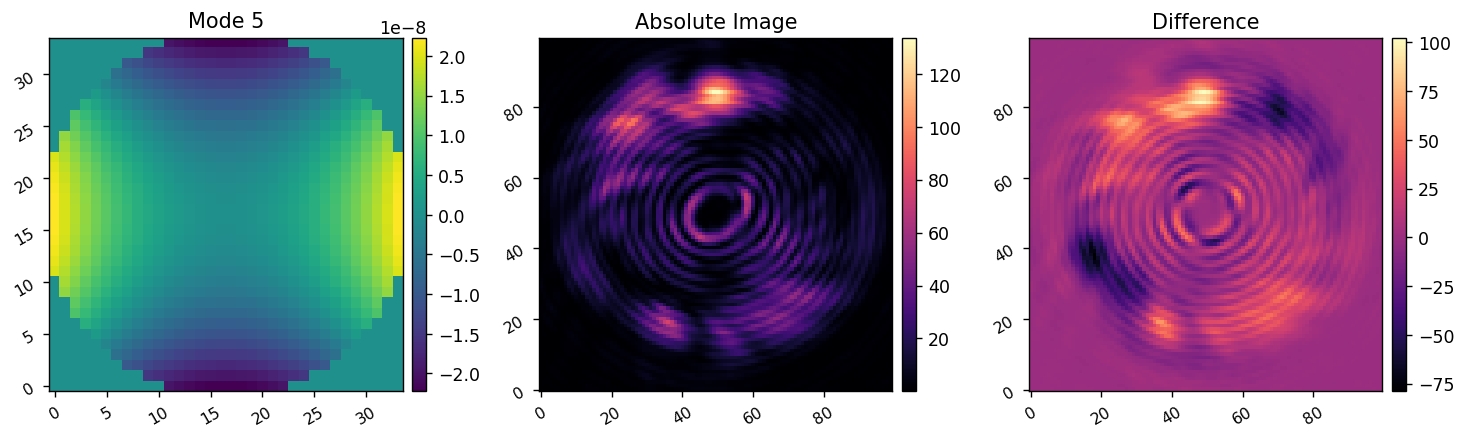

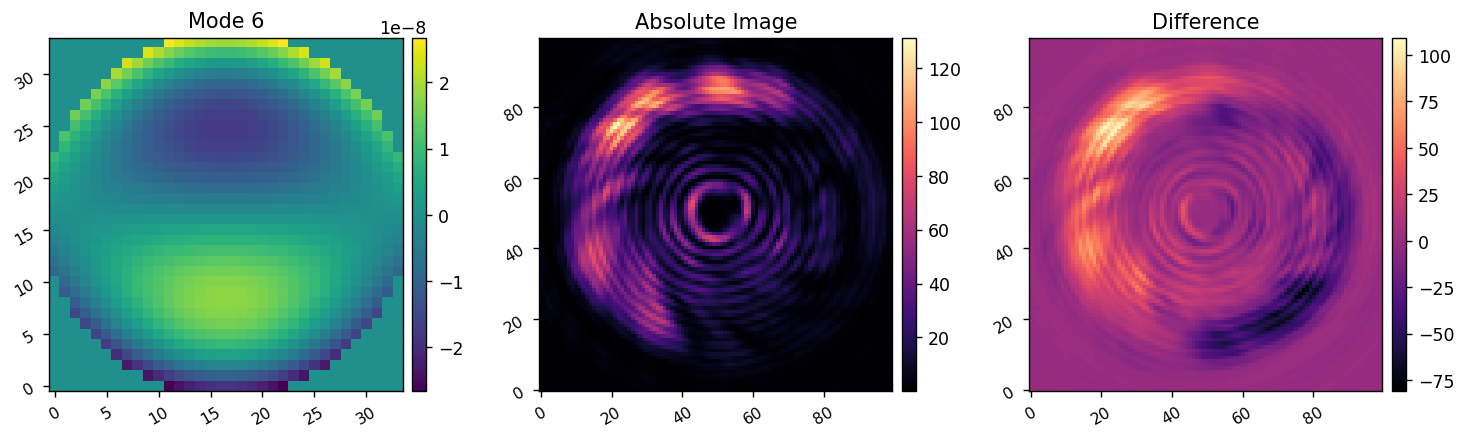

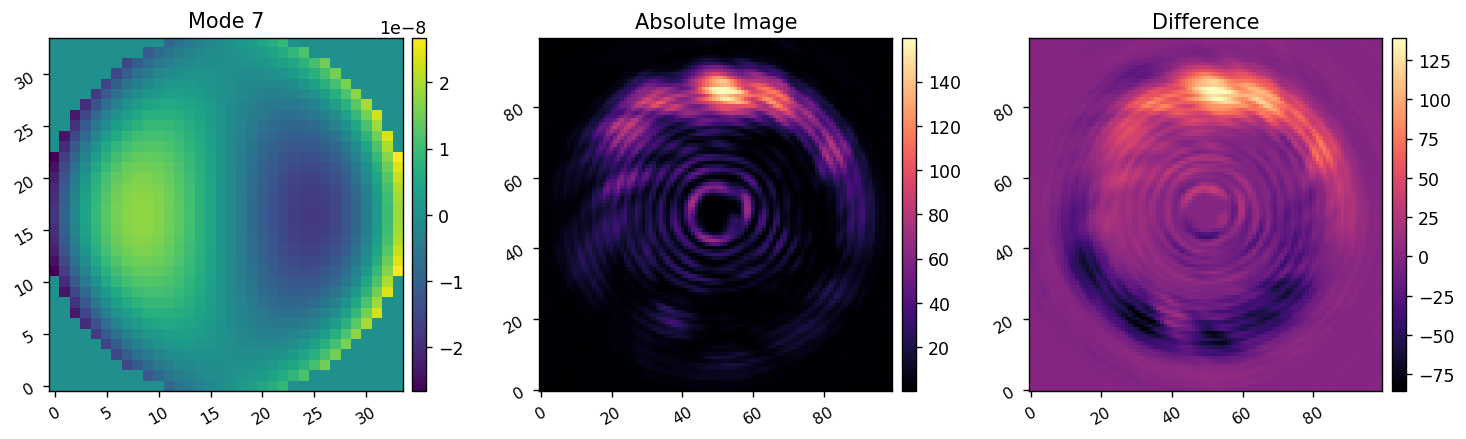

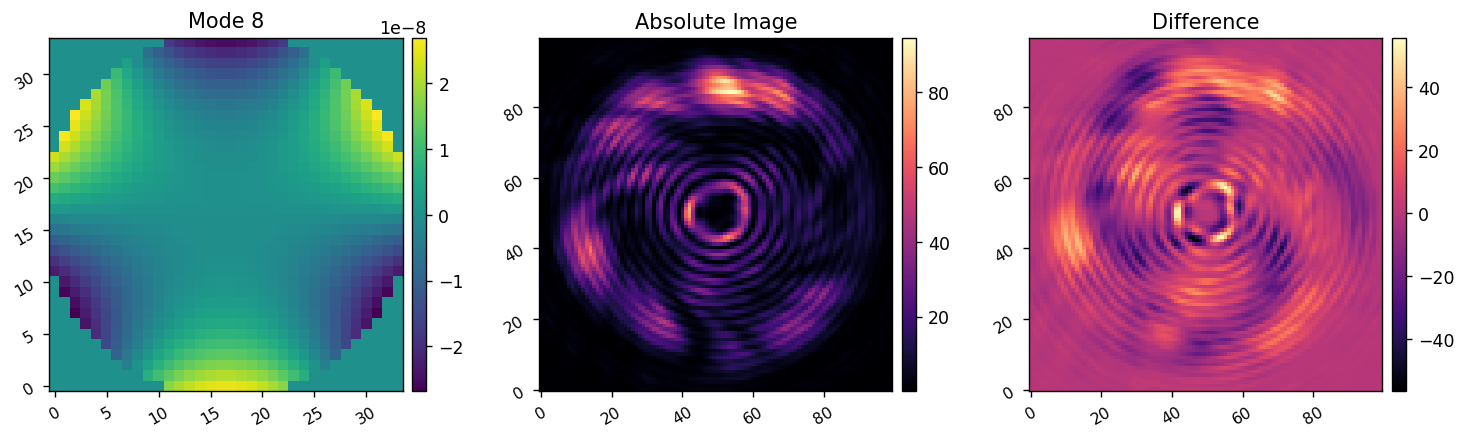

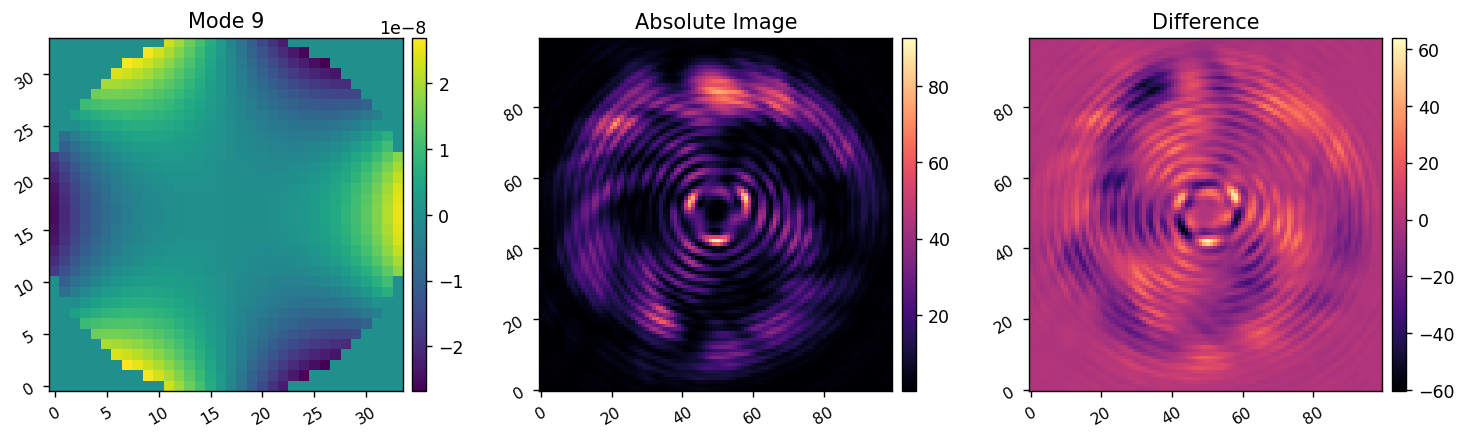

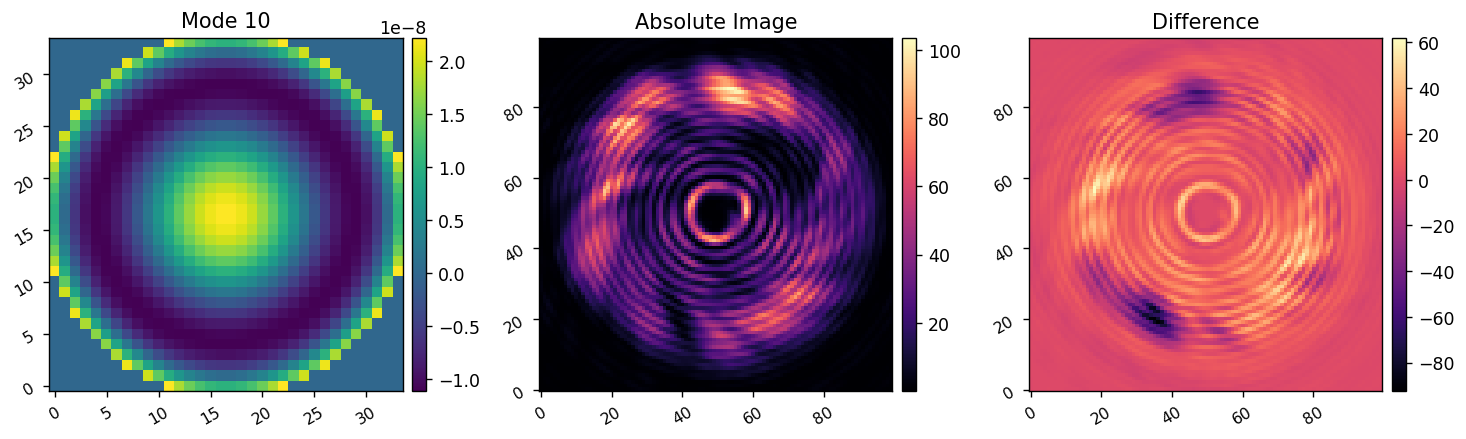

In [169]:
reload(lina.llowfsc)
M.setattr('WFE', WFE)
M.zero_dm()
# M.set_dm(dhc)
M.setattr('use_vortex', True)
zer_rm = lina.llowfsc.calibrate_without_fsm(M, control_mask, dm_modes=dm_modes, amps=10e-9, plot=True)
control_matrix = lina.utils.TikhonovInverse(zer_rm, 0)

In [170]:
U, s, Vt = xp.linalg.svd(zer_rm, full_matrices=False)
s.max()/s.min()

array(3.89107541)

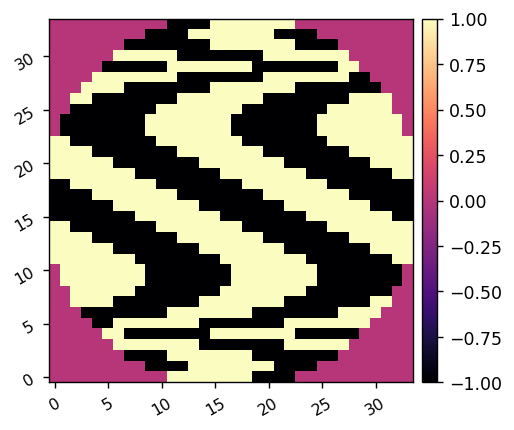

In [171]:
had_modes = lina.utils.create_hadamard_modes(M.dm_mask)
had_modal_matrix = had_modes[:, M.dm_mask]

imshow1(had_modes[8])

In [172]:
reload(lina.llowfsc)
M.zero_dm()
M.setattr('use_vortex', True)

had_rm = lina.llowfsc.calibrate_without_fsm(M, control_mask,  dm_modes=had_modes, amps=10e-9, plot=0)


In [173]:
U, s, Vt = xp.linalg.svd(had_rm, full_matrices=False)
svd_dm_modes = Vt.dot(had_modal_matrix)
s.max()/s.min()

array(39685.28099203)

In [63]:
U.shape, Vt.shape, had_modal_matrix.shape

((2796, 1024), (1024, 1024), (1024, 952))

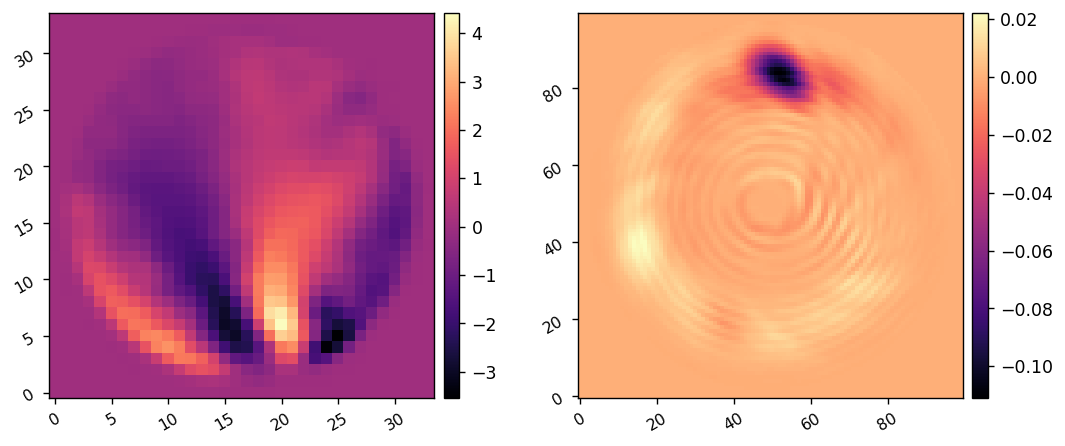

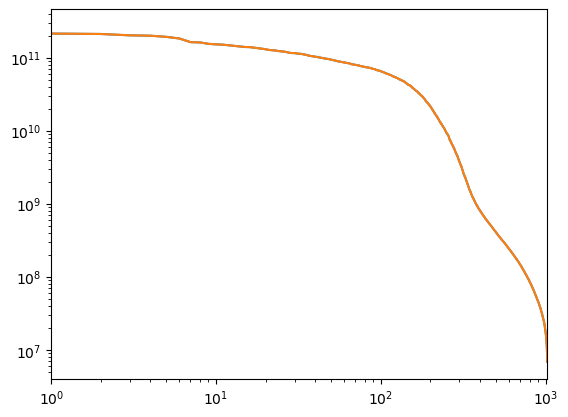

In [174]:
plt.plot(ensure_np_array(s))
plt.loglog(ensure_np_array(s))
plt.xlim([1, 1024])

i=0
svd_dm_mode = xp.zeros_like(M.DM.command)
svd_dm_mode[M.dm_mask] = svd_dm_modes[i]
wfs_mode = xp.zeros_like(locam_ref_im)
wfs_mode[control_mask] = U[:, i]
imshow2(svd_dm_mode, wfs_mode)

116.35528356555025 nm


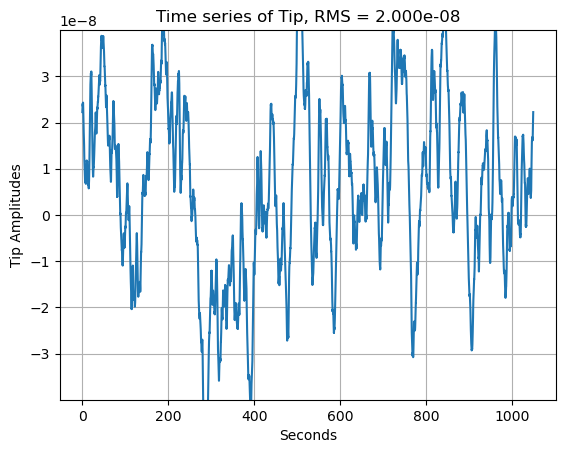

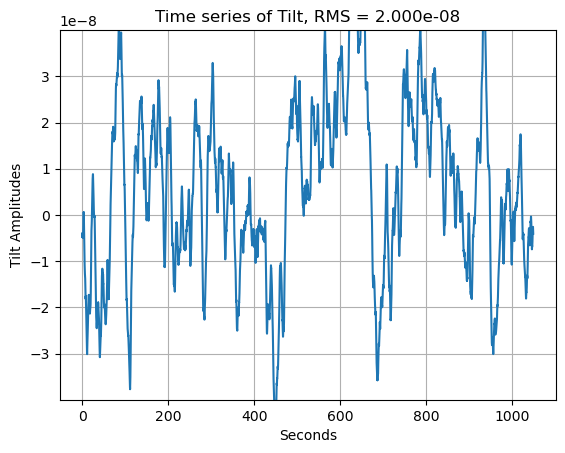

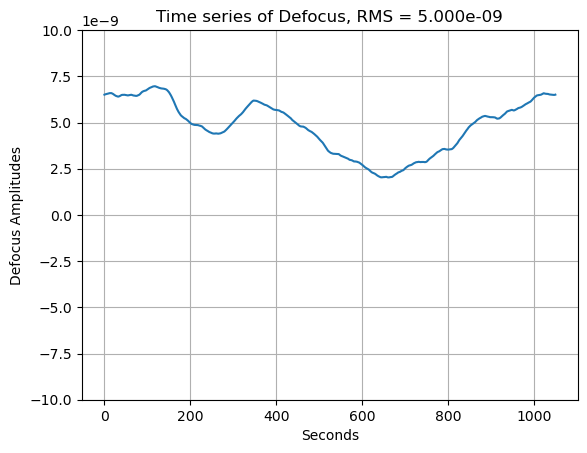

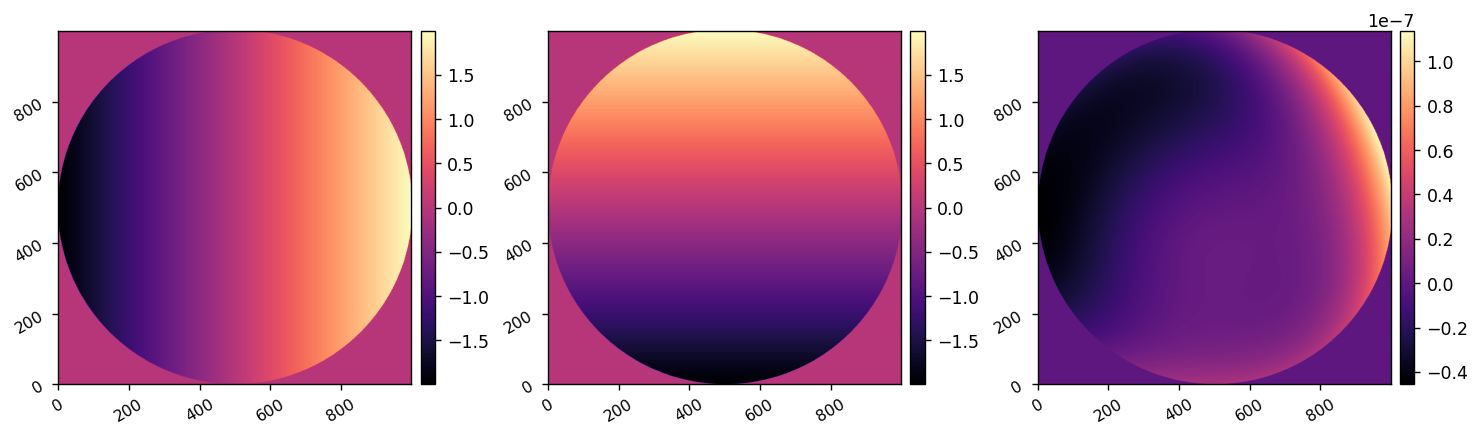

In [175]:
import lina.psds as psds
reload(psds)

total_pupil_diam = 2.4*u.m
jitter = 40*u.mas

mag = (total_pupil_diam / M.dm_beam_diam).decompose().value
jitter_at_dm = mag*jitter
tt_pv_to_rms = 1/4
tt_at_pupil_pv = np.tan(jitter_at_dm).value * M.dm_beam_diam
tt_at_pupil_rms = tt_at_pupil_pv * tt_pv_to_rms
print(tt_at_pupil_rms.to(u.nm))

fmax = 1000*u.Hz
tmax = 10*u.s
# wfe_modes_rms = np.array([tt_at_pupil_rms.to_value(u.m)] * 2)
# wfe_modes_rms = np.array(2*[tt_at_pupil_rms.to_value(u.m)] + 8*[5e-9])
wfe_modes_rms = np.array(2*[20e-9] + 8*[5e-9])
knee_freqs = np.array([0.03]*2 + [0.001]*8) * u.Hz

N_wfe_modes = len(wfe_modes_rms)
wfe_modes = lina.utils.create_zernike_modes(M.APMASK, nmodes=N_wfe_modes, remove_modes=1)

freqs, times = psds.generate_freqs(Nf=2**20+1, f_max=fmax)

wfe_time_series = xp.zeros((N_wfe_modes+1, len(times)))
wfe_time_series[0] = xp.array(times)
slope = 4
for i in range(N_wfe_modes):
    f_knee = knee_freqs[i]
    psd = psds.kneePSD(freqs, 1, f_knee.to_value(u.Hz), slope)
    coeff = psds.generate_time_series(psd, fmax, rms=1, seed=12+i)
    wfe_time_series[i+1] = wfe_modes_rms[i] * xp.array(coeff)

# resample the time series such that the spacing steps are 2ms to simulate LLOWFSC at 500Hz
# and limit the maximum time to the desired t_max
wfe_time_series = wfe_time_series[:, ::4]
times = wfe_time_series[0]
# wfe_time_series = wfe_time_series[:, times<tmax.to_value(u.s)]

times = wfe_time_series[0]
tip = wfe_time_series[1]
tilt = wfe_time_series[2]
defocus = wfe_time_series[3]

psds.plot_time_series(times, tip, name='Tip')
psds.plot_time_series(times, tilt, name='Tilt')
psds.plot_time_series(times, defocus, name='Defocus')

lo_wfe = xp.sum( wfe_time_series[1:, 500, None, None] * wfe_modes, axis=0)
imshow3(wfe_modes[0], wfe_modes[1], lo_wfe)

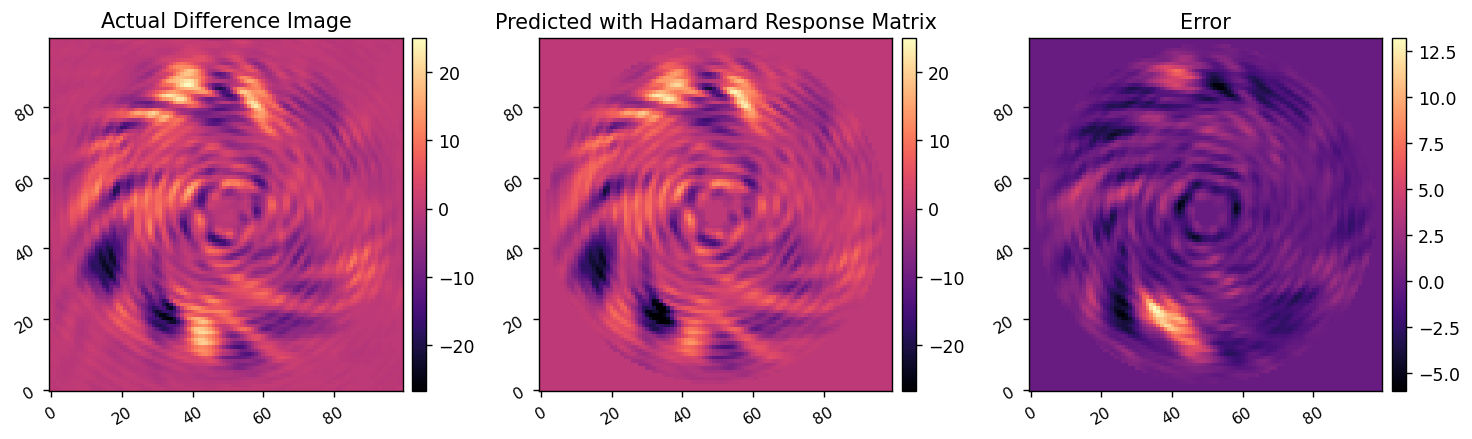

In [176]:
M.setattr('WFE', WFE)
M.zero_dm()
M.set_dm(dh_commands[-1])
del_ref_im_0 = M.snap_locam() - locam_ref_im
del_ref_im_had = xp.zeros_like(locam_ref_im)
del_ref_im_had[control_mask] = had_rm.dot(had_modal_matrix.dot(dh_commands[-1][M.dm_mask])/1024)
double_diff = control_mask*del_ref_im_0-del_ref_im_had
imshow3(del_ref_im_0, del_ref_im_had, double_diff, 
        'Actual Difference Image', 'Predicted with Hadamard Response Matrix', 'Error', 
        vmin1=xp.min(del_ref_im_0), vmax1=xp.max(del_ref_im_0), 
        vmin2=xp.min(del_ref_im_0), vmax2=xp.max(del_ref_im_0),
        # vmin3=xp.min(del_ref_im_0), vmax3=xp.max(del_ref_im_0), 
        )

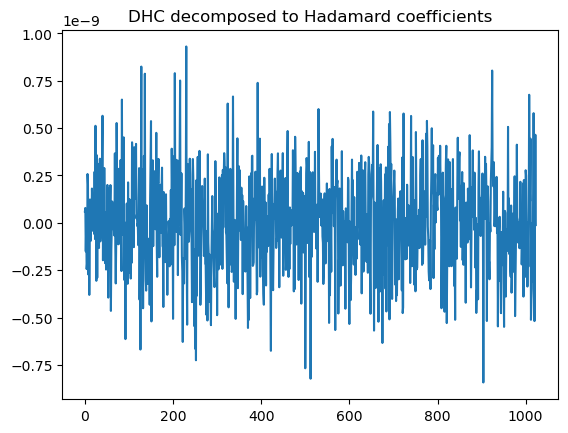

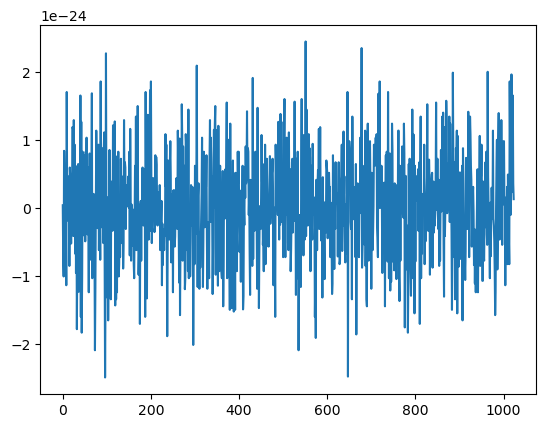

In [177]:
had_coeff = lina.utils.lstsq(had_modes, dh_commands[-1])
had_coeff_2 = had_modal_matrix.dot(dh_commands[-1][M.dm_mask]) /1024
plt.plot(had_coeff.get())
plt.title('DHC decomposed to Hadamard coefficients')
plt.show()
plt.plot(had_coeff.get() - had_coeff_2.get())
plt.show()

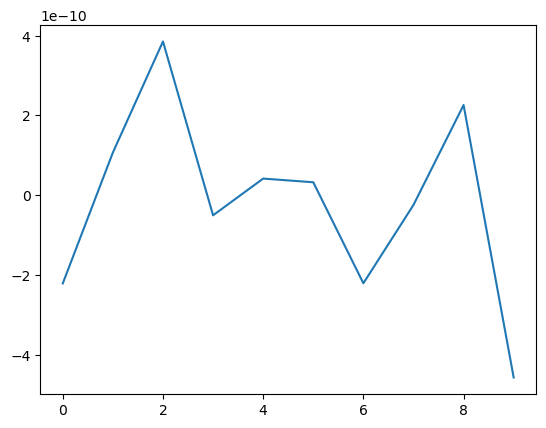

In [178]:
coeff = control_matrix.dot(double_diff[control_mask])
plt.plot(coeff.get())

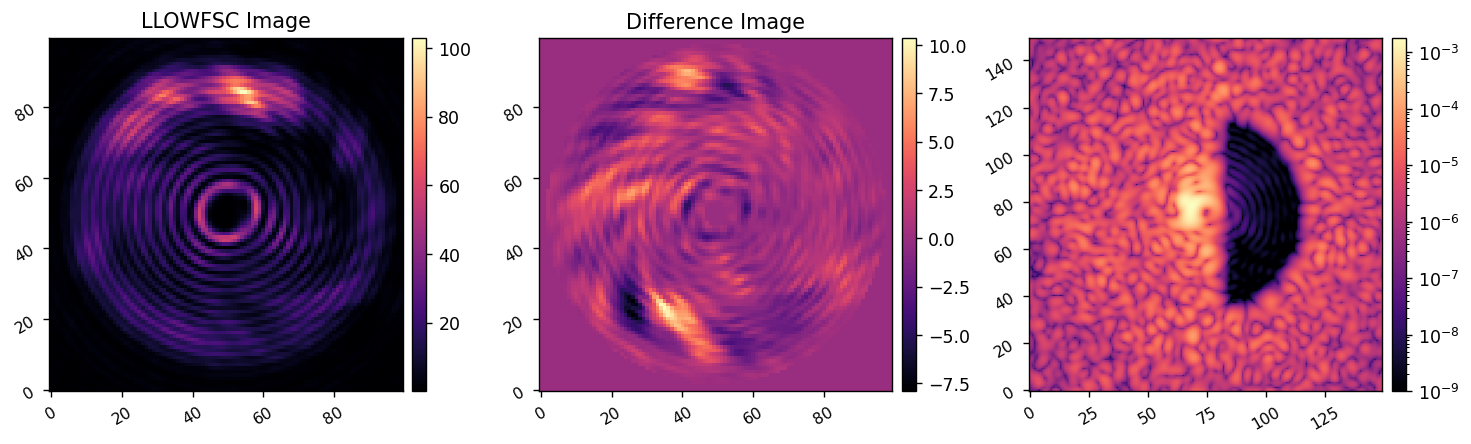

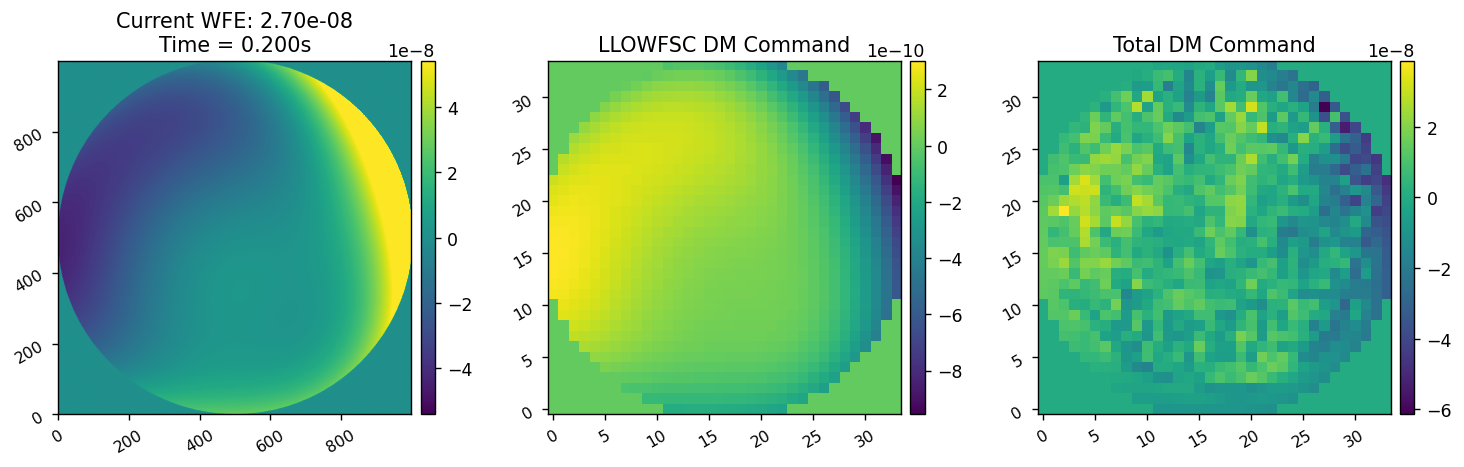

In [179]:
reload(lina.llowfsc)

del_ref_im_had = xp.zeros_like(locam_ref_im)
del_ref_im_had[control_mask] = had_rm.dot(had_modal_matrix.dot(dh_commands[-1][M.dm_mask])/1024)

gains = xp.array(2*[0.5] + 8*[0])

llowfsc_dict_1 = lina.llowfsc.run_sim(M, 
                                        WFE,
                                        # locam_ref_im, 
                                        locam_ref_im+del_ref_im_had, 
                                        control_mask, 
                                        control_matrix, 
                                        wfe_time_series[:,:21], 
                                        # wfe_time_series[:,2000:2000+20], 
                                        # wfe_time_series, 
                                        wfe_modes, 
                                        dm_modes=dm_modes, 
                                        dh_command=copy.copy(dh_commands[-1]), 
                                        gain=gains,  
                                        leakage=0.02, 
                                        plot=True, 
                                        # plot_all=True,
                                        # return_coro_ims=True,
                                        )

gains = xp.array(2*[0.5] + 8*[0.25])

llowfsc_dict_2 = lina.llowfsc.run_sim(M, 
                                        WFE,
                                        # locam_ref_im, 
                                        locam_ref_im+del_ref_im_had, 
                                        control_mask, 
                                        control_matrix, 
                                        wfe_time_series[:,20:101], 
                                        # wfe_time_series[:,2000:2000+20], 
                                        # wfe_time_series, 
                                        wfe_modes, 
                                        dm_modes=dm_modes, 
                                        dh_command=copy.copy(dh_commands[-1]), 
                                        gain=gains,  
                                        leakage=0.02,
                                        plot=True, 
                                        # plot_all=True,
                                        # return_coro_ims=True,
                                        )

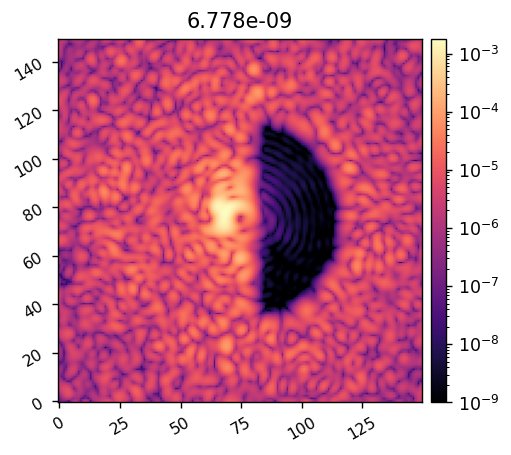

In [180]:
total_coro_im = llowfsc_dict_2['coro_ims'][50:].mean(axis=0)
mean_ni = xp.mean(total_coro_im[coro_roi])
imshow1(total_coro_im, f'{mean_ni:.3e}', lognorm=True, vmin=1e-9)

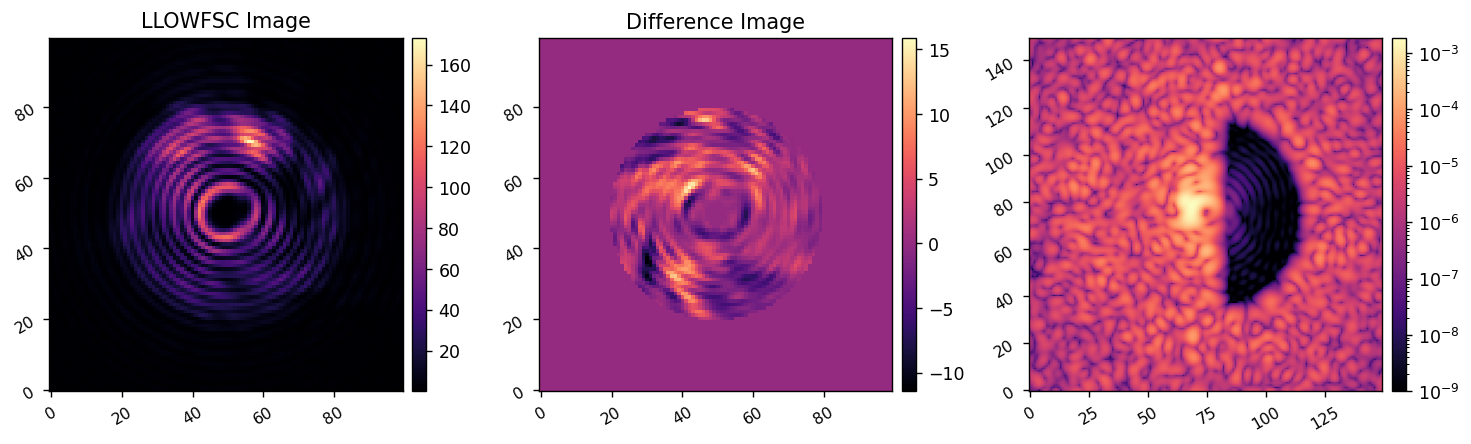

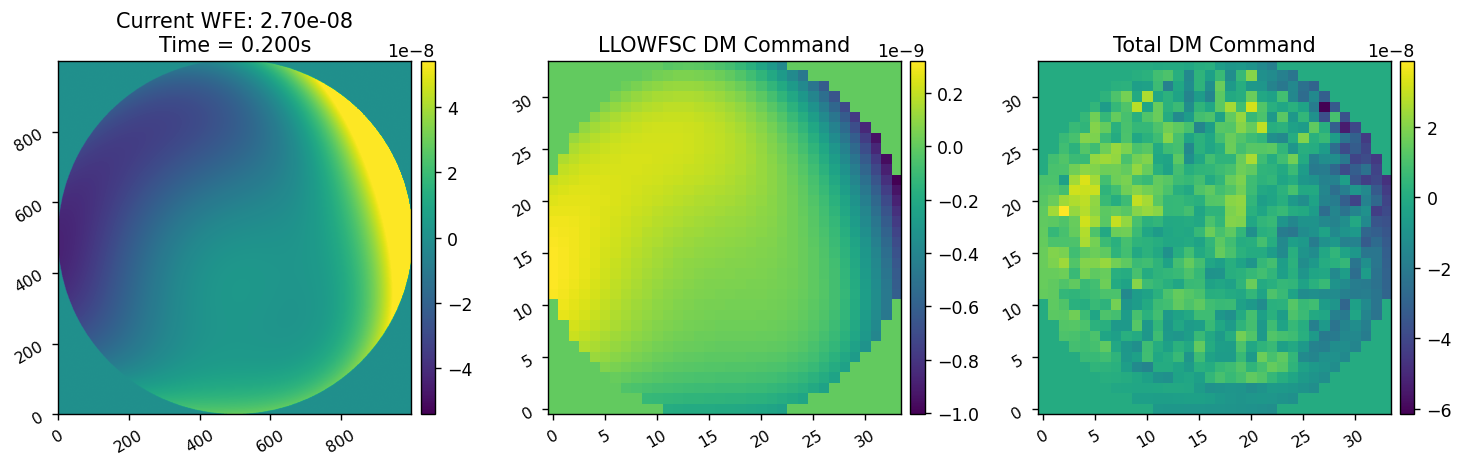

In [163]:
reload(lina.llowfsc)

Nitr = 20

M.zero_dm()
M.setattr('WFE', WFE)

gains_seq = [
    xp.array(2*[0.5] + 8*[0]),
    xp.array(2*[0.5] + 3*[0.1] + 5*[0.0]),
    xp.array(2*[0.5] + 3*[0.1] + 5*[0.05]),
    xp.array(2*[0.5] + 3*[0.2] + 5*[0.1]),
    xp.array(2*[0.5] + 3*[0.2] + 5*[0.2]),
]

old_dhc = xp.zeros((M.Nact,M.Nact))
for i in range(dh_commands.shape[0]):
    del_ref_im_had = xp.zeros_like(locam_ref_im)
    del_ref_im_had[control_mask] = had_rm.dot(had_modal_matrix.dot(dhc[M.dm_mask])/1024)
    gains = gains_seq[i]

    start_ind = i*Nitr
    end_ind = (i+1)*Nitr

    llowfsc_dict = lina.llowfsc.run_sim(M, 
                                            WFE,
                                            # locam_ref_im, 
                                            locam_ref_im+del_ref_im_had, 
                                            control_mask, 
                                            control_matrix, 
                                            wfe_time_series[:,start_ind:end_ind+1], 
                                            # wfe_time_series[:,2000:2000+20], 
                                            # wfe_time_series, 
                                            wfe_modes, 
                                            dm_modes, 
                                            dh_command=copy.copy(dh_commands[i]),
                                            gain=gains,
                                            leakage=0.02,
                                            plot=True, 
                                            # plot_all=True,
                                            # return_coro_ims=True,
                                            )

    # utils.save_pickle(f'/npool/nvme/kianmilani/esc-data/{today}_llowfsc_sim_data_{i+1}.pkl', llowfsc_dict)
    